## Predicting eye gaze using CNN

Importing image processing and pytorch modules

In [3]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import scipy.io as sio
from sklearn.model_selection import train_test_split

### Loading the data

In [5]:
path_folders = "./MPIIGaze/Data/Normalized/"
folders_normalized = !ls $path_folders
img_height, img_width = 36, 60
eye_right_arr, eye_left_arr, gaze_right_arr, gaze_left_arr, pose_right_arr, pose_left_arr = np.empty((1,1,img_height,img_width)),np.empty((1,1,img_height,img_width)),np.empty((1,3)),np.empty((1,3)),np.empty((1,3)),np.empty((1,3))

for idx_folder, folder in enumerate(folders_normalized):
    path_files = path_folders + folder
    files_normalized = !ls $path_files
    
    for idx_file, file_mat in enumerate(files_normalized):
        file_normalized_path = path_files + "/" + file_mat
        f = sio.loadmat(file_normalized_path)
        data = f['data']
        right_eye_img = data['right'][0,0]['image'][0,0]
        left_eye_img = data['left'][0,0]['image'][0,0]
        
        right_eye_img = right_eye_img.reshape((right_eye_img.shape[0],1,right_eye_img.shape[1],right_eye_img.shape[2]))
        left_eye_img = left_eye_img.reshape((left_eye_img.shape[0],1,left_eye_img.shape[1],left_eye_img.shape[2]))

        eye_right_arr = np.vstack((eye_right_arr,right_eye_img))
        eye_left_arr = np.vstack((eye_left_arr,left_eye_img))
        gaze_right_arr = np.vstack((gaze_right_arr,data['right'][0,0]['gaze'][0,0]))
        gaze_left_arr = np.vstack((gaze_left_arr,data['left'][0,0]['gaze'][0,0]))
        pose_right_arr = np.vstack((pose_right_arr,data['right'][0,0]['pose'][0,0]))
        pose_left_arr = np.vstack((pose_left_arr,data['left'][0,0]['pose'][0,0]))

eye_right_arr = eye_right_arr[1:]
eye_left_arr = eye_left_arr[1:]
gaze_right_arr = gaze_right_arr[1:]
gaze_left_arr = gaze_left_arr[1:]
pose_right_arr = pose_right_arr[1:]
pose_left_arr = pose_left_arr[1:]

print("Loaded {} images".format(len(eye_right_arr)))

Loaded 213658 images


We have loaded 213658 right eye images and 213658 left eye images. Each eye image is of size 36x60.

In [6]:
eye_right_arr.shape

(213658, 1, 36, 60)

### Data Transformation

Let's convert the 3d gaze array into 2d array of theta and phi

In [ ]:
def get2dGaze(x,y,z):
    '''
    Description:
    Convert 3d gaze into 2d vector with theta and phi as output
    
    Input:
    x,y,z are 3d eye gaze parameters
    
    Returns:
    List:[theta, phi]
    
    Reference: 
    https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild
    '''
    
    theta = math.asin(-y)
    phi = math.atan2(-x, -z)
    
    return (theta, phi)

In [ ]:
gaze_right_2d_arr = np.array([get2dGaze(x,y,z) for x,y,z in gaze_right_arr])
gaze_left_2d_arr = np.array([get2dGaze(x,y,z) for x,y,z in gaze_left_arr])

After implementing the 2d vector for representing 3d space of eye gaze, we found out that 3d representation works much better hence skipped this part.

In [ ]:
# plt.figure(figsize=(14,6))
# plt.subplot(1,2,1)
# plt.title('Right eye gaze 2d array')
# plt.scatter([gaze[0] for gaze in gaze_right_2d_arr], [gaze[1] for gaze in gaze_right_2d_arr])
# plt.xlabel("Theta")
# plt.ylabel("Phi")
# plt.subplot(1,2,2)
# plt.title('Left eye gaze 2d array')
# plt.scatter([gaze[0] for gaze in gaze_left_2d_arr], [gaze[1] for gaze in gaze_left_2d_arr])
# plt.xlabel("Theta")
# plt.ylabel("Phi")
# plt.show()

Let's check the distribution of eye gaze coordinates.

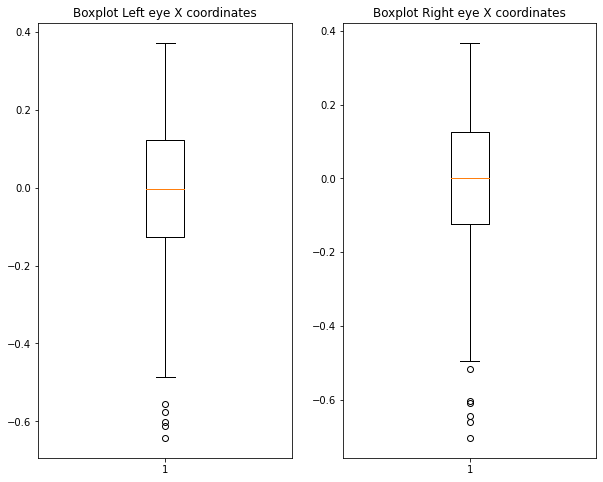

In [61]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title("Boxplot Left eye X coordinates")
plt.boxplot(gaze_left_arr[:,0])
plt.subplot(1,2,2)
plt.title("Boxplot Right eye X coordinates")
plt.boxplot(gaze_right_arr[:,0])
plt.show()

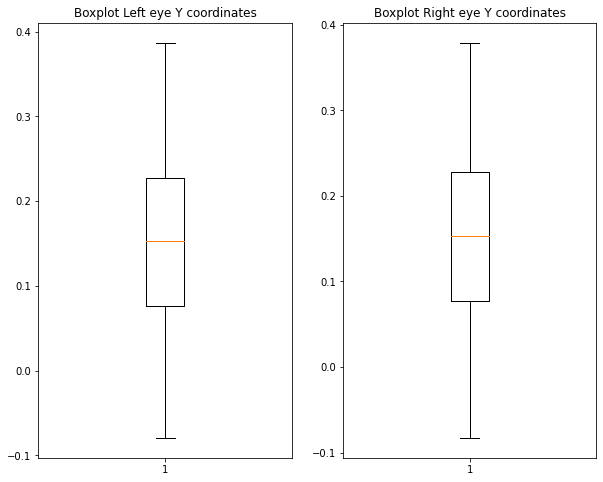

In [62]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title("Boxplot Left eye Y coordinates")
plt.boxplot(gaze_left_arr[:,1])
plt.subplot(1,2,2)
plt.title("Boxplot Right eye Y coordinates")
plt.boxplot(gaze_right_arr[:,1])
plt.show()

### Model Description

 #### Let's build a CNN model to predict x,y,z coordinates of the eye gaze from given image

#### Following is the architecture used for this CNN model. Input image is a grayscale image of 1 dimension.

In [7]:
class EyeGazeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(50*6*12, 500)
        self.fc2 = nn.Linear(500, 3)

    def forward(self, x):
        y1 = self.pool1(F.relu(self.conv1(x)))
        y2 = self.pool2(F.relu(self.conv2(y1)))
        y3 = y2.view(-1, 50*6*12)
        y4 = self.fc1(y3)
        y5 = self.fc2(y4)
        return y5

model = EyeGazeModel().to(torch.double)
Loss = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

/usr/local/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [69]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            520
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            25,050
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,800,500
├─Linear: 1-6                            1,503
Total params: 1,827,573
Trainable params: 1,827,573
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            520
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            25,050
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,800,500
├─Linear: 1-6                            1,503
Total params: 1,827,573
Trainable params: 1,827,573
Non-trainable params: 0

### Training model

In [17]:
def train_model(images_train_data, labels_train_data, images_test_data, labels_test_data, epochs=5, batch_size=16):
    train_loss_history = []
    test_loss_history = []

    loss_total = 0
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        loss_total = []
        for i in range(0,len(labels_train_data),batch_size) :
            images_train = images_train_data[i:i+batch_size]
            labels_train = labels_train_data[i:i+batch_size]
            optimizer.zero_grad()
            yhat = model(images_train)
            loss = Loss(yhat,labels_train)
            loss_total.append(loss)
            loss.backward()
            optimizer.step()
        train_loss_history.append(torch.mean(torch.DoubleTensor(loss_total)))
        print("Train loss:",train_loss_history[-1].item())
        loss_total = []
        for i in range(0,len(labels_test_data),batch_size) :
            images_test = images_test_data[i:i+batch_size]
            labels_test = labels_test_data[i:i+batch_size]
            with torch.no_grad():
                yhat_test = model(images_test)
                loss_test = Loss(yhat_test,labels_test)
                loss_total.append(loss_test)
        test_loss_history.append(torch.mean(torch.DoubleTensor(loss_total)))
#         print("Train loss:",train_loss_history[-1].item(),"Test loss:",test_loss_history[-1].item()) 

In [8]:
eye_arr = np.vstack((eye_left_arr/255, eye_right_arr/255))

gaze_arr = np.vstack((gaze_left_arr, gaze_right_arr))

images_train, images_test, labels_train, labels_test = train_test_split(eye_arr, gaze_arr, test_size=0.2)
images_train = torch.DoubleTensor(images_train)
labels_train = torch.DoubleTensor(labels_train)
images_test = torch.DoubleTensor(images_test)
labels_test = torch.DoubleTensor(labels_test)

In [71]:
print(images_train.size(), images_test.size())

torch.Size([341852, 1, 36, 60]) torch.Size([85464, 1, 36, 60])


We have divided training and test samples in 80% and 20%. Training size is 341852 and test size is 85464.

In [21]:
%%time
train_model(images_train, labels_train, images_test, labels_test)

Epoch: 1/5
Train loss: 0.003591651489722652
Epoch: 2/5
Train loss: 0.0024288570776217168
Epoch: 3/5
Train loss: 0.002162747031906189
Epoch: 4/5
Train loss: 0.002017049263681232
Epoch: 5/5
Train loss: 0.0019204840840662898
CPU times: user 2h 25min 17s, sys: 13min 15s, total: 2h 38min 32s
Wall time: 1h 17min 53s


As we have 341852 images, the first loss itself is very less as we are using batch size of 16 images. Hence, 5 epochs were enough to train the model to get a good enough loss.

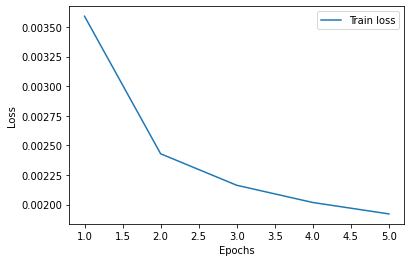

In [36]:
plt.plot( range(1,6), train_loss_history, label = "Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing the model

In [27]:
batch_size=16
test_loss_history = []
loss_total = []
yhat = np.array([0,0,0])
for i in range(0,len(labels_test),batch_size) :
    images_test_batch = images_test[i:i+batch_size]
    labels_test_batch = labels_test[i:i+batch_size]
    with torch.no_grad():
        yhat_test = model(images_test_batch)
        yhat = np.vstack((yhat, yhat_test.numpy()))
        loss_test = Loss(yhat_test,labels_test_batch)
        loss_total.append(loss_test)
test_loss_history.append(torch.mean(torch.DoubleTensor(loss_total)))
print("Test loss:",test_loss_history[-1].item())

Test loss: 0.0018882664221587114


### Saving the model

In [22]:
torch.save(model, 'fully_trained_model.pt')

We are saving the trained model and using it later on test images taken from a webcam in a different file.

Next steps are to test the model on live test images taken from webcam.